# FB2NEP Workbook 2 – Data Collection and Cleaning

Version 0.1.0

This workbook introduces:

- Data collection pipelines in nutritional epidemiology.
- Types of variables (continuous, categorical, ordinal, count) and how we code them.
- Identification of implausible or inconsistent values.
- Handling missing data (MCAR, MAR, MNAR – overview).
- Simple validation and visual checks.
- Practical issues such as “prefer not to say”, test questions, and units.

Run the first code cell to set up the repository and load the dataset.

In [2]:
# FB2NEP bootstrap cell – use in *all* workbooks
#
# This cell:
# - Locates scripts/bootstrap.py starting from this notebook.
# - Executes it with runpy and explicitly calls init().
# - After this, you have in the *notebook* namespace:
#       df          – main FB2NEP synthetic dataset
#       CTX         – context object with repo_root etc.
#       REPO_ROOT   – path to the repository root
#       CSV_REL     – relative path to the CSV
#       IN_COLAB    – True/False

import pathlib
import runpy

bootstrap_candidates = [
    "scripts/bootstrap.py",
    "../scripts/bootstrap.py",
    "../../scripts/bootstrap.py",
]

bootstrap_ns = None

for rel in bootstrap_candidates:
    p = pathlib.Path(rel)
    if p.exists():
        print(f"Loading bootstrap from: {p}")
        # Execute bootstrap.py and capture its global namespace as a dict
        bootstrap_ns = runpy.run_path(str(p))
        break
else:
    raise FileNotFoundError(
        "Could not find scripts/bootstrap.py. "
        "Please check that you are running this notebook inside fb2nep-epi."
    )

if "init" not in bootstrap_ns:
    raise RuntimeError("bootstrap.py does not define an init() function.")

# Call init() from bootstrap.py – this does all the heavy lifting
df, CTX = bootstrap_ns["init"]()

# Expose a few convenience names in the notebook
REPO_ROOT = CTX.repo_root
CSV_REL = CTX.csv_rel
IN_COLAB = CTX.in_colab

print("Repository root:", REPO_ROOT)
print("Main dataset:", CSV_REL)
print("df shape:", df.shape)
print("IN_COLAB:", IN_COLAB)


Loading bootstrap from: scripts/bootstrap.py
Dataset found: data/synthetic/fb2nep.csv ✅
Repository root: /Users/gunter/Documents/fb2nep-epi
Main dataset: data/synthetic/fb2nep.csv
df shape: (25000, 27)
IN_COLAB: False


## 1. Variable types and coding

Before we think about *where* data come from, we need to understand *what kind of things* we can measure.

In this workbook we will repeatedly use three broad types of variables:

- **Continuous variables**  
  Numeric measurements on a (more or less) continuous scale.  
  Examples: `BMI`, `SBP`, `energy_kcal`, `fruit_veg_g_d`.

- **Categorical variables (nominal)**  
  Categories without an inherent order.  
  Examples: `sex`, `SES_class`, `smoking_status`.

- **Ordinal variables**  
  Categories with a meaningful order, but without fixed distances between levels.  
  Examples: `IMD_quintile` (1 = most deprived, 5 = least deprived), `physical_activity` (`low` / `moderate` / `high`).

Later, in the workbook on sampling and representativeness, we will use these variable types to compare our synthetic FB2NEP cohort to reference surveys (such as NHANES). Here we focus on:

- how different types of variables are **stored** and **summarised** in Python,  
- what happens when we **encode** answers into numbers, and  
- how we can already spot some problems just from the way data are coded.

<div style="border-left: 4px solid #e0a000; padding: 0.8em 1em; background: #f3f7ff;">
<strong>UK Socio-Economic Status (SES) Classification – A Short Guide</strong>

In UK public health and survey research, socio-economic status is often measured using the **NRS Social Grades**.  
(NRS: National Readership Survey) They are widely used in national surveys, market research, and sometimes in epidemiology.

### 1. The Six NRS Social Grades

| Grade | Meaning                                      | Typical occupations                                 |
|-------|----------------------------------------------|-----------------------------------------------------|
| **A** | Higher managerial, administrative, professional | CEOs, senior civil servants   |
| **B** | Intermediate managerial, administrative, professional | Teachers, mid-level managers, engineers         |
| **C1** | Supervisory, clerical, junior managerial/professional | Office staff, technicians                      |
| **C2** | Skilled manual workers                      | Electricians, plumbers, carpenters                   |
| **D** | Semi-skilled & unskilled manual workers       | Factory workers, delivery drivers                    |
| **E** | Casual/lowest-grade workers, unemployed, pensioners | Long-term unemployed, some retirees             |

These grades correlate with income, education, and job security — but they are not identical to any one of those.

### 2. The Two-Level System: ABC1 vs C2DE

Many surveys collapse the six groups into two wider bands:

- **ABC1**: higher or intermediate SES (A + B + C1)  
- **C2DE**: lower SES (C2 + D + E)

This simplified classification is the one used in the FB2NEP synthetic dataset (`SES_class`).

### 3. Strengths and Limitations

**Strengths**
- Simple, widely recognised, consistently used in UK surveys.
- Shows clear associations with health behaviours and outcomes.

**Limitations**
- Coarse: mixes diverse occupations within broad categories.
- Not portable outside the UK (occupation structures differ).
- Based on *occupation*, which is awkward for students, retirees, carers, and precarious workers.
- Does not map neatly to education or income.

### 4. Harmonisation Issues Across Datasets (Education, Income, Occupation)

SES looks deceptively simple, but different datasets measure **different things**:

- **NHANES (US)** uses *education* (≤ high school / some college / college+).
- **NDNS (UK)** often uses education or income *alongside* NRS social grade.
- **EPIC** and **UK Biobank** use mixtures of *occupation*, *education*, *income*, *area-level deprivation*.
- **FB2NEP** uses *occupation-based social grades* (ABC1 / C2DE).
- **International surveys** (OECD, WHO STEPS, Eurostat) usually use education because occupation and income do not translate across countries.

This immediately creates problems for harmonisation.

#### Why SES ≠ education ≠ income ≠ occupation

SES is a **latent construct** — an underlying social position that cannot be measured directly.  
Different operationalisations capture different aspects:

- **Education** → long-term human capital, cognitive resources, health literacy.  
- **Income** → current material resources and capacity to purchase goods.  
- **Occupation** → job security, working conditions, prestige, social capital.  
- **Area-level deprivation** → neighbourhood environment, access to services.

These correlate, but not perfectly.  
> Example: a highly educated PhD student may have low income; a long-serving electrician may earn more than a junior academic but be coded as C2, not ABC1.

Using one variable to stand in for SES always loses information.

#### Why the UK is unusual

The UK has a long-standing, highly standardised **occupation-based SES system**:

- **NRS Social Grades (A–E)**, created for media and market research, became widely used in public health research.
- It maps occupation → social class → purchasing power in a historically industrial society.
- It remains deeply embedded in UK survey infrastructure (ONS, NDNS, IPSOS, BBC, etc.).

This is unusual internationally:

- Most countries **do not** have a national occupation-based SES scale.
- Education is the default SES variable in the US, EU, and WHO datasets because it is the most stable and portable across contexts.
- Occupations, job structures and prestige systems differ too much between countries to harmonise consistently.

Thus, using ABC1/C2DE outside the UK is difficult.

#### What happens when two SES systems must be aligned?

Any harmonisation requires **strong assumptions**.  
Typical problems:

- **Different constructs**: NHANES education ≠ UK NRS grades.  
- **Different number of categories**: one is binary (ABC1/C2DE), one has three or six categories.  
- **Different conceptual meaning**: "College+" is not equivalent to "professional/managerial".  
- **Non-monotonic relationships**: more education ≠ higher job grade in every case.

Example mismatches:
- A retired senior civil servant → NRS A/B but education may be “≤ High school”.
- A university graduate in a temporary low-paid job → college+ + C2 or D.
- A tradesperson with high income → C2 but with higher income than many ABC1 workers.

#### Implications for analysis

Harmonisation is always an approximation.  
When aligning SES across datasets:

- **Be explicit** about the mapping rules you apply.  
- **Check frequencies** and identify categories that map poorly.  
- **Document data loss** (e.g. collapsing categories removes nuance).  
- **Acknowledge uncertainty** introduced by any recoding.  
- **Perform sensitivity analyses** where possible (e.g., different mapping schemes).

Teaching takeaway:  
*SES is a theoretical construct, not a variable.  
Every dataset measures it differently.  
Harmonisation therefore requires judgement, transparency, and a clear statement of limitations.*


### 5. Takeaway

SES is not a single “true” attribute.  
Different countries, surveys and traditions measure it differently.  
For cross-dataset comparisons (e.g. NHANES vs FB2NEP), SES must be **translated** with care and the uncertainties should be stated clearly.
</div>

<div style="border-left: 4px solid #e0a000; padding: 0.8em 1em; background: #f3f7ff;">

<strong>Excursion: Index of Multiple Deprivation (IMD)</strong>


**Index of Multiple Deprivation (IMD)** is the main *area-based* measure of deprivation used in England.  
It does **not** describe an individual’s SES, but the **deprivation level of the small area** where they live.

---

#### 1. What IMD measures

IMD combines **seven domains** of deprivation into a single index:

1. **Income**  
2. **Employment**  
3. **Education, skills and training**  
4. **Health and disability**  
5. **Crime**  
6. **Barriers to housing and services**  
7. **Living environment**

Each small area (Lower Layer Super Output Area, LSOA; ~1,500 people) receives:

- a **rank** (1 = most deprived area in England),  
- and derived **deciles** or **quintiles**.

In FB2NEP we use **IMD quintiles**, where:

- **1 = most deprived**,  
- **5 = least deprived**.

---

#### 2. IMD vs individual SES

IMD is **area-level**; SES (such as NRS social grade or education) is usually **individual-level**.

They capture related but different aspects:

- IMD reflects the **context** of a neighbourhood  
  (local income, employment, environment, access to services, crime).  
- SES reflects an individual’s **social position**  
  (education, occupation, income, security).

Examples:

- A highly educated person may live in an IMD 1 area (cheap housing in a deprived neighbourhood).  
- A low-income person may live in an IMD 4–5 area (long-term tenant in a relatively affluent area).

**Key point:** IMD is very useful for understanding **health inequalities and neighbourhood effects**,  
but it must not be treated as “the same thing” as individual SES.

---

#### 3. Why IMD appears in FB2NEP

Many UK cohort studies and surveys (e.g. NDNS, UK Biobank, some cancer registries) link IMD to participants via postcode.  
Typical uses include:

- describing the **deprivation profile** of the cohort,  
- studying **gradients** in risk factors and disease by area-level deprivation,  
- adjusting for area-level deprivation as a potential **confounder**.

FB2NEP mirrors this practice by including `IMD_quintile`:

- It lets us explore **inequalities** in diet and health,  
- and it sets up later Public Health exercises where IMD plays a central role.

---

#### 4. Practical reminders for analysis

- Treat IMD as an **ordered categorical** variable (e.g. quintiles), not as a precise continuous scale.  
- Be clear in write-ups that IMD is **area-based**, not a personal SES measure.  
- Consider showing results by **both** individual SES (e.g. ABC1/C2DE) **and** IMD where possible.

</div>


<div style="border-left: 4px solid #e0a000; padding: 0.8em 1em; background: #f3f7ff;">
<strong>Excursion: Physical Activity – Why Categories Are Vague (and Why It Matters)</strong>

Physical activity is **essential** in nutritional epidemiology, yet it is one of the **least precisely measured** variables in any dataset.  
Even “good” surveys struggle because *activity is multi-dimensional* and hard to summarise in a single score.

---

#### 1. Why physical activity is hard to measure

Physical activity varies by:

- **Intensity** (light, moderate, vigorous)  
- **Type** (walking, cycling, work-related, leisure, sport, chores)  
- **Duration**  
- **Frequency**  
- **Context** (commuting, occupation, exercise, childcare)

This creates an enormous range of behaviours that cannot easily be captured by simple categories.

---

#### 2. How surveys measure activity

Most population studies rely on **self-report**, for example:

- “How many minutes per week of moderate physical activity do you do?”  
- “How often do you walk for at least 10 minutes?”  
- “How active is your job?”  
- Likert scales such as *low / moderate / high*.

More detailed instruments exist (IPAQ, GPAQ), but they still rely on participant recall and judgement.  
Even objectively measured PA (accelerometers, wearables) must be **translated into categories**, and the choice of cut-points affects results.

---

#### 3. What FB2NEP uses (and why)

FB2NEP includes a variable:

- **`physical_activity`** = `"low"`, `"moderate"`, `"high"`

This is typical in cohort studies where detailed accelerometer data are not available.

However, these categories are:

- **Vague**: “moderate” for one person may be “vigorous” for another.  
- **Self-assessed**: depends on how active participants *feel*.  
- **Context-dependent**: a manual worker and a sedentary office worker with the same walking minutes may not classify themselves the same way.

In other words:  
> *These categories provide a rough indicator of activity level, useful for broad comparisons but not precise enough to infer true energy expenditure.*

---

#### 4. Common problems in analysis

1. **Non-comparability across surveys**  
   - NHANES uses MET-minutes.  
   - NDNS uses questionnaire-based categorisation.  
   - UK Biobank uses a mixture (IPAQ-like questions + accelerometer subsample).  
   - EPIC uses a 4-level Cambridge index.

   These systems are **not equivalent**.

2. **Categorisation introduces information loss**  
   - Collapsing minutes, intensity, and context into one label removes detail.  
   - “Moderate” may hide large differences in actual activity.

3. **Cut-off sensitivity**  
   - If “moderate” is defined differently across studies, results are not directly comparable.

4. **Residual confounding**  
   - PA categories are too crude to fully capture lifestyle differences  
     (e.g. fitness, occupation, active commuting).

---

#### 5. Why this matters for nutritional epidemiology

Physical activity is a major confounder for:

- Energy intake  
- Obesity  
- Cardiovascular risk  
- Metabolic markers  
- Sedentary behaviour  
- Diet–disease associations

Using crude PA categories increases **measurement error**, which tends to:

- **Bias effect estimates toward the null**,  
- **Inflate residual confounding**,  
- Make PA look “less important” than it is.

---

#### 6. Takeaway

- Physical activity categories are **useful**, but **imprecise**.  
- Never over-interpret “low/moderate/high” as exact physiological measures.  
- When comparing datasets, check how PA was measured and consider harmonisation issues.  
- If possible, perform **sensitivity analyses** using alternative cut-points.

</div>


In [8]:
# 1.1 Quick look at the synthetic cohort and variable types

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Show the first 5 rows
display(df.head())

# Show the data types of the first few columns
df.dtypes.head(20)

,id,baseline_date,follow_up_years,age,sex,menopausal_status,IMD_quintile,SES_class,smoking_status,physical_activity,...,ssb_ml_d,fibre_g_d,alcohol_units_wk,salt_g_d,plasma_vitC_umol_L,urinary_sodium_mmol_L,CVD_incident,CVD_date,Cancer_incident,Cancer_date
0,1,2011-05-27,6.44,59,M,NaN,5,ABC1,current,low,...,159.0,15.2,0.0,4.1,40.3,94.6,1,2016-11-14,1,2015-10-01
1,2,2010-08-14,7.50,60,M,NaN,4,ABC1,never,low,...,206.0,11.2,0.0,5.0,36.1,104.4,0,NaN,0,NaN
2,3,2012-04-28,7.57,54,F,post,4,ABC1,former,moderate,...,233.0,26.4,0.0,7.3,46.3,130.9,0,NaN,0,NaN
3,4,2015-01-20,5.71,67,F,post,3,ABC1,never,low,...,399.0,10.5,8.0,4.9,31.4,78.0,0,NaN,0,NaN
4,5,2013-04-10,6.30,70,M,NaN,1,C2DE,current,moderate,...,600.0,25.9,0.0,9.1,33.1,154.1,0,NaN,0,NaN


id                         int64
baseline_date             object
follow_up_years          float64
age                        int64
sex                       object
menopausal_status         object
IMD_quintile               int64
SES_class                 object
smoking_status            object
physical_activity         object
family_history_cvd         int64
family_history_cancer      int64
BMI                      float64
SBP                      float64
energy_kcal              float64
fruit_veg_g_d            float64
red_meat_g_d             float64
ssb_ml_d                 float64
fibre_g_d                float64
alcohol_units_wk         float64
dtype: object

In [9]:
# 1.2 Examples of how we summarise different variable types

# Continuous example: BMI
if "BMI" in df.columns:
    print("BMI – continuous variable")
    display(df["BMI"].describe())

# Categorical example: sex
if "sex" in df.columns:
    print("\nsex – categorical (nominal)")
    print(df["sex"].value_counts(dropna=False))

# Ordinal example: IMD_quintile
if "IMD_quintile" in df.columns:
    print("\nIMD_quintile – stored as numbers, but conceptually ordered categories")
    print(df["IMD_quintile"].value_counts(dropna=False).sort_index())

BMI – continuous variable


count    24995.000000
mean        27.148542
std          4.547444
min         13.700000
25%         24.100000
50%         27.200000
75%         30.200000
max         46.300000
Name: BMI, dtype: float64


sex – categorical (nominal)
sex
F    13054
M    11946
Name: count, dtype: int64

IMD_quintile – stored as numbers, but conceptually ordered categories
IMD_quintile
1    5650
2    5928
3    5439
4    4484
5    3499
Name: count, dtype: int64


### 1.3 How we (should) use different types

- For **continuous variables** we normally use summaries such as *mean*, *standard deviation*,
  histograms, boxplots, and regression models with the variable on its original scale.

- For **categorical variables** we usually use *counts* and *proportions*, and cross-tabulations
  (contingency tables), for example `smoking_status × CVD_incident`.

- For **ordinal variables**, we technically have two options:

  1. **Treat them as ordered categories**  
     (e.g. proportional-odds models, cumulative logit models, or ordered bar charts).  
     This respects the fact that the categories have an order *but not a measurable distance*.

  2. **Code them as 0/1/2/3 and analyse them as if they were continuous**  
     (e.g. using them in linear regression).

  ⚠️ **This second option is risky** because it quietly assumes:
     - the “gap” between *low → moderate* is the same size as *moderate → high*;  
     - and that those distances are meaningful on a numeric scale.

     These assumptions are almost never justified.

     Treating ordinal scales as continuous can:
     - distort effect sizes,  
     - produce misleading trends,  
     - violate model assumptions,  
     - and give regression coefficients that look precise but have no real-world meaning.
 
     > *It works by accident, not by principle.*

**Best practice:**  
Use ordinal models when possible; if you collapse the scale to treat it as continuous, justify it clearly and perform sensitivity checks.


For this module we keep a simple rule of thumb:

> Ordinal variables are *not automatically* continuous.  
> If you code them as numbers, you must still think about whether treating
> "low → moderate → high" as evenly spaced is sensible for your question.


### 1.4 Simple validation example: smoking and CVD

As a quick **sanity check**, we can look at how often incident cardiovascular disease (CVD) occurs in different **smoking categories**.

- `smoking_status` is a **categorical exposure** (for example, never / former / current).
- `CVD_incident` is a **binary outcome** (0 = no event, 1 = event).

A natural question is:

> *“Is incident CVD more common in some smoking groups than others?”*

To explore this, we can use `pandas.crosstab` with `normalize="index"`:

- Each **row** corresponds to one smoking category.
- Each **cell** is the **proportion** of participants in that smoking group with / without incident CVD.
- Rows therefore sum to 1 (100%).

This does **not** prove causality, and it ignores confounders (for example, age, sex, SES),  
but it is a very useful descriptive check:

- Does the pattern roughly match what we expect (higher CVD in current smokers than never smokers)?  
- Are there any obviously strange values (for example, zero events in a large group)?

In the next cell we compute and display this row-normalised cross-tabulation.


In [ ]:
if {"smoking_status", "CVD_incident"}.issubset(df.columns):
    tab = pd.crosstab(df["smoking_status"], df["CVD_incident"], normalize="index")
    print("Proportion with incident CVD by smoking status:")
    display(tab)

Proportion with incident CVD by smoking status:


CVD_incident,0,1
smoking_status,,
current,0.789433,0.210567
former,0.896850,0.103150
never,0.902948,0.097052


### 1.5 Making ordinal variables explicit in the data

Some variables in `df` are **inherently ordered**, even though they are stored as numbers or plain strings:

- `IMD_quintile`: 1 (most deprived) → 5 (least deprived).  
- `physical_activity`: `"low"` → `"moderate"` → `"high"`.

If we leave them as ordinary integers/strings, pandas and most modelling functions will treat them either as:

- **purely categorical** (no order at all), or  
- **continuous** (for example, using 1–5 as if the gaps were equal).

Both can be misleading:

- Treating them as **unordered categories** throws away the ranking information.  
- Treating them as **continuous** quietly assumes that the “distance” from 1→2 is the same as 4→5, which is rarely justified.

A better approach is to mark them explicitly as **ordered categorical variables**.  
This preserves the ranking (1 < 2 < … < 5; low < moderate < high) without pretending that the gaps are equal.

In the next cell we:

- create `IMD_quintile_ord` and `physical_activity_ord` as ordered `Categorical` variables;  
- keep the original columns so you can see both side by side.

Later, when we model these variables, we can use methods appropriate for ordered data (for example, ordered bar plots, stratified summaries, or proportional-odds models), rather than treating them as plain numbers.


In [ ]:


if "IMD_quintile" in df.columns:
    df["IMD_quintile_ord"] = pd.Categorical(
        df["IMD_quintile"],
        categories=[1, 2, 3, 4, 5],
        ordered=True,
    )

if "physical_activity" in df.columns:
    df["physical_activity_ord"] = pd.Categorical(
        df["physical_activity"],
        categories=["low", "moderate", "high"],
        ordered=True,
    )

cols_to_show = [
    c for c in ["IMD_quintile", "IMD_quintile_ord", "physical_activity", "physical_activity_ord"]
    if c in df.columns
]

if cols_to_show:
    display(df[cols_to_show].head())

,IMD_quintile,IMD_quintile_ord,physical_activity,physical_activity_ord
0,5,5,low,low
1,4,4,low,low
2,4,4,moderate,moderate
3,3,3,low,low
4,1,1,moderate,moderate


## 2. Data collection pipelines

In nutritional epidemiology, data usually come from several sources that are linked together:

- **Questionnaires and interviews** (for example, food frequency questionnaires, 24-hour recalls, lifestyle questionnaires).
- **Laboratory measurements** (for example, blood biomarkers, urinary biomarkers).
- **Clinical examinations** (for example, blood pressure, anthropometry).
- **Registers and administrative data** (for example, hospital episode statistics, cancer registries, mortality data).
- **Public datasets and surveys** (for example, NHANES in the United States, NDNS in the United Kingdom).

Typical steps in a data collection pipeline are:

1. **Sampling and recruitment** of participants.
2. **Baseline data collection**:
   - Questionnaires completed on paper, online, or via interview.
   - Clinical and anthropometric measurements.
   - Biospecimen collection for later laboratory analysis.
3. **Follow-up data collection**:
   - Repeat questionnaires or clinic visits.
   - Linkage to health registers to obtain information on disease outcomes.
4. **Data entry, coding and merging**:
   - Scanning or manual entry of questionnaires.
   - Coding of free-text responses.
   - Merging laboratory, questionnaire and register data using a unique participant identifier.

The synthetic FB2NEP dataset represents a **merged cohort** where these steps have already taken place. The underlying logic, however, is the same as in real-world studies such as NHANES or NDNS.


### 2.1 Units and harmonisation

When combining or comparing datasets, we must pay attention to **units** and **coding schemes**:

- Blood lipids: mmol/L (UK, Europe) vs mg/dL (US).
- Height: centimetres vs inches.
- Education and SES: different qualification systems across countries.
- Physical activity: self-reported categories vs device-based measures.

Before merging or comparing datasets we should always check:

1. Units and reference ranges (for example, SBP in mmHg vs kPa).  
2. Coding manuals for questionnaires (for example, education categories).  
3. Whether local scores (for example, deprivation indices) are comparable at all.

In later workbooks, when we compare FB2NEP to NHANES or NDNS, we will see that harmonisation sometimes requires judgement and inevitably involves some information loss.

## 3. Coding and information loss

When we turn real-world phenomena into variables, we always **lose information** – long before we fit any models.

Examples:

- Turning height and weight into **BMI** loses information about body shape.  
  Two people with very different height and weight can have the *same* BMI.
- Turning continuous BMI into three categories (for example,
  *normal / overweight / obese*) throws away all variation **within** each band.
- Turning detailed income into a few SES categories (`ABC1` vs `C2DE`) hides
  differences *within* each broad class.

Why do we code and collapse variables?

> *Coding* refers to the systematic assignment of numerical or categorical codes to raw data values (e.g., converting BMI into obesity categories such as 0 = underweight, 1 = normal, 2 = overweight, 3 = obese) to facilitate statistical analysis, grouping, or modelling.

- To shorten questionnaires.
- To make models simpler and more stable.
- To produce tables that fit on one slide or in a paper.

The trade-off is:

> More coding and categorisation → simpler communication,  
> but **less information** and sometimes **more bias**.

In practice, we should:

- keep the **rawest sensible version** of each variable;
- document every coding step;
- think about what has been **lost** at each stage.

### 3.1 Example: collapsing continuous BMI into categories

BMI itself is already a **derived** measure:

- It combines *height* and *weight* into a single number (`kg/m²`);
- It does **not** distinguish between muscle and fat mass;
- It treats all people with the same BMI as equivalent, even if their body
  composition is very different.

On top of that, we often **categorise** BMI:

- “normal weight”, “overweight”, “obese”, sometimes with more bands;
- convenient for guidelines and tables;
- but it discards differences within each band  
  (for example, BMI 30.1 vs 39.9 are both just “obese”).

> **Please note**  
> BMI cut-off points associated with metabolic risk differ across ethnic groups.  
> Several populations develop type 2 diabetes at **lower BMI** than White populations.

<div style="border-left: 4px solid #e0a000; padding: 0.8em 1em; background: #f3f7ff;">

### Ethnic-specific BMI thresholds for equivalent diabetes risk

Using a cohort of 1.47 million adults in England, Caleyachetty et al. (2021) compared the  
BMI level at which different ethnic groups have the **same age- and sex-adjusted incidence**  
of type 2 diabetes as White adults at **BMI 30 kg/m²**.

| Ethnic group | BMI associated with equivalent diabetes risk | 95% CI |
|--------------|----------------------------------------------|--------|
| **White**        | 30.0 kg/m² (reference)                       | –      |
| **South Asian**  | **23.9 kg/m²**                               | 23.6–24.0 |
| **Black**        | **28.1 kg/m²**                               | 28.0–28.4 |
| **Chinese**      | **26.9 kg/m²**                               | 26.7–27.2 |
| **Arab**         | **26.6 kg/m²**                               | 26.5–27.0 |

**Key teaching point:**  
A BMI of 30 kg/m² does **not** represent the same metabolic risk across all ethnicities.  
For some groups (notably South Asian and Chinese populations), clinically relevant risk  
appears at **much lower BMI values**.

*Source:*  
Caleyachetty R. et al. *Lancet Diabetes & Endocrinology* 2021;9:419–26.  
</div>

In the code below we:

1. Start from continuous BMI.  
2. Create three broad categories using `pd.cut`.  
3. Compare the summary of the original BMI distribution with the counts in each category.

This is purely **illustrative** – it shows how easy it is to throw away information.
In later weeks, we will discuss when categorisation might be useful and when it is
better to keep BMI continuous (or use other measures such as waist circumference).

#### 3.1.1 Visual example: same BMI, different body composition

BMI cannot distinguish between **fat mass** and **muscle mass**.

In the illustration below, both individuals have (hypothetically) the **same BMI**,
but very different body composition:

- one predominantly muscular,
- one with higher body fat.

![Two individuals with identical BMI but different body composition](../_assets/bmi_same_bmi_diff_bodyshape.png)

This is why BMI is useful as a **crude screening tool**, but not a perfect
measure of adiposity in individuals.


In [13]:
# 3.1 Example: collapsing continuous BMI into categories

if "BMI" in df.columns:
    bmi = df["BMI"].copy()

    # Very simple categories for illustration only
    bmi_cat = pd.cut(
        bmi,
        bins=[0, 25, 30, np.inf],
        labels=["normal", "overweight", "obese"],
        right=False,
    )

    print("Original BMI (continuous) summary:")
    display(bmi.describe())

    print("\nBMI categories (illustrative):")
    print(bmi_cat.value_counts(dropna=False))


Original BMI (continuous) summary:


count    24995.000000
mean        27.148542
std          4.547444
min         13.700000
25%         24.100000
50%         27.200000
75%         30.200000
max         46.300000
Name: BMI, dtype: float64


BMI categories (illustrative):
BMI
overweight    10373
normal         7921
obese          6701
NaN               5
Name: count, dtype: int64


#### 3.2 Self-reported height and weight

Many large studies (including some national surveys) use **self-reported** height
and weight instead of measured values.

Typical patterns:

- People tend to **over-report height**.
- People tend to **under-report weight**.
- The bias is not random – it often depends on sex, age, and actual body size.

Consequences:

- BMI from self-report is usually **biased downwards**.
- Misclassification across BMI categories (normal / overweight / obese) is common.
- Associations between BMI and health outcomes can be **biased** if we ignore
  this measurement error.

For teaching purposes, it is helpful to remember that:

> BMI combines two measured variables (height, weight)  
> and those measurements themselves may be biased.


## 4. Identifying implausible or inconsistent values

Even carefully collected data may contain values that are *implausible* or *wrong*.
Examples include:

- Anthropometric values outside physiological limits (for example, BMI < 10 kg/m²).
- Blood pressure values that are extremely low or high.
- Energy intakes that are incompatible with life over the long term.
- Men who are recorded as being “post-menopausal”.

In practice we define **simple rules** to flag such values for review, and in some cases to exclude them from analysis.

In [14]:
# 4.1 Example: BMI range check
#
# These cut-offs are illustrative. In a real study they should be
# chosen with clinical input and clear documentation.

if "BMI" in df.columns:
    print("Summary of BMI:")
    display(df["BMI"].describe())

    implausible_bmi = df[(df["BMI"] < 10) | (df["BMI"] > 70)]
    print(f"Number of participants with BMI < 10 or > 70: {len(implausible_bmi)}")
    display(implausible_bmi.head())

Summary of BMI:


count    24995.000000
mean        27.148542
std          4.547444
min         13.700000
25%         24.100000
50%         27.200000
75%         30.200000
max         46.300000
Name: BMI, dtype: float64

Number of participants with BMI < 10 or > 70: 0


,id,baseline_date,follow_up_years,age,sex,menopausal_status,IMD_quintile,SES_class,smoking_status,physical_activity,...,alcohol_units_wk,salt_g_d,plasma_vitC_umol_L,urinary_sodium_mmol_L,CVD_incident,CVD_date,Cancer_incident,Cancer_date,IMD_quintile_ord,physical_activity_ord


In [15]:
# 4.2 Example: SBP (systolic blood pressure) range check

if "SBP" in df.columns:
    print("Summary of SBP:")
    display(df["SBP"].describe())

    implausible_sbp = df[(df["SBP"] < 70) | (df["SBP"] > 260)]
    print(f"Number of participants with SBP < 70 or > 260 mmHg: {len(implausible_sbp)}")
    display(implausible_sbp.head())

Summary of SBP:


count    23649.000000
mean       158.799780
std         12.965594
min        108.900000
25%        150.000000
50%        158.100000
75%        166.800000
max        220.000000
Name: SBP, dtype: float64

Number of participants with SBP < 70 or > 260 mmHg: 0


,id,baseline_date,follow_up_years,age,sex,menopausal_status,IMD_quintile,SES_class,smoking_status,physical_activity,...,alcohol_units_wk,salt_g_d,plasma_vitC_umol_L,urinary_sodium_mmol_L,CVD_incident,CVD_date,Cancer_incident,Cancer_date,IMD_quintile_ord,physical_activity_ord


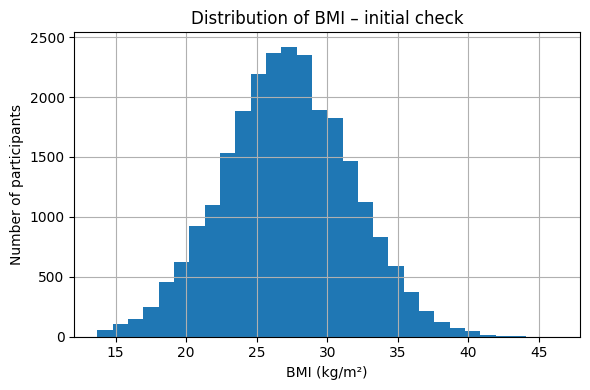

In [16]:
# 4.3 Distribution of BMI – visual check

%matplotlib inline

if "BMI" in df.columns:
    plt.figure(figsize=(6, 4))
    df["BMI"].hist(bins=30)
    plt.xlabel("BMI (kg/m²)")
    plt.ylabel("Number of participants")
    plt.title("Distribution of BMI – initial check")
    plt.tight_layout()
    plt.show()

### 4.4 Energy Intake Plausibility and the Goldberg Cut-off

In nutritional epidemiology, a recurring question is whether **reported energy intake (EI)** is
compatible with the **energy a person is expected to expend**.  
The **Goldberg cut-off** is a widely used, reproducible approach to detect *implausible*
self-reported energy intakes.

#### 1. Core idea

The method compares:

\[
\frac{EI}{EE}
\]

where **EE** is the *minimum* energy expenditure expected for that person.

If the ratio is *too low*, the individual is likely to be an **under-reporter**.

#### 2. Steps in the Goldberg method

1. **Estimate Basal Metabolic Rate (BMR)**  
   Usually via predictive equations (Schofield, Henry, or similar) using:
   - age  
   - sex  
   - weight (and occasionally height)

2. **Assume a minimum plausible Physical Activity Level (PAL)**  
   A typical assumption is **PAL = 1.55** for a “sedentary to lightly active” lifestyle.  
   This gives the minimum Total Energy Expenditure (TEE):

   \[
   \text{TEE}_{\min} = \text{BMR} \times \text{PAL}
   \]

3. **Compute the Goldberg ratio**

   \[
   r = \frac{\text{Reported EI}}{\text{TEE}_{\min}}
   \]

4. **Compare the ratio to a cut-off**

   A common lower limit is **0.76–0.80**, derived by combining:
   - day-to-day variation in energy intake,
   - variation in BMR prediction,
   - sampling duration.

   If \( r < \text{cut-off} \), the intake is considered **implausibly low**.

#### 3. Interpretation

The rule does *not* say the individual is deliberately misreporting.  
It indicates that the **reported intake is statistically incompatible** with sustaining
basic physiological requirements over time.

Examples:
- A reported EI of **900 kcal/day** for a healthy adult is implausible.  
- A physically active person reporting 1,200 kcal/day may also be flagged.

#### 4. Why the Goldberg cut-off is widely used

- **Transparent** and fully formula-based.  
- **Simple** and implementable in any dataset.  
- **Consistent** across studies.  
- Helps identify **outliers** before modelling.

However, the method is designed for population-level plausibility screening, **not** as a
diagnostic tool for individual behaviour.

---

### 4.5 Limitations of the Goldberg Cut-off

Although influential, the Goldberg approach has important limitations:

#### (a) Strong assumptions about PAL  
Using a fixed PAL (for example 1.55) ignores the wide variation in physical activity
between individuals.  
TEE may be substantially higher or lower than assumed, causing:
- *false positives* (flagged as under-reporting but plausible),  
- *false negatives* (severe under-reporting may not be flagged if activity is low).

#### (b) BMR prediction error  
Predictive equations for BMR introduce error:
- ±5–10% for many individuals,
- larger for those with atypical body composition.

If BMR is misestimated, the Goldberg ratio becomes misleading.

#### (c) One-day (or few-day) intake is **not** habitual intake  
Short-term 24-h recalls show **large day-to-day variation**, making the ratio unstable.

#### (d) Cannot distinguish *intentional dieting*  
Low reported intakes may reflect:
- short-term restriction,
- illness,
- poor recall,
- dieting behaviour.

The cut-off treats all as “implausible”.

#### (e) Systematic bias in self-reporting  
Energy misreporting is **not random**:
- overweight individuals tend to under-report energy, especially snacks and high-fat foods;
- some demographic groups systematically under- or over-report.

Thus the Goldberg decision can itself **introduce bias**, for example:
- removing more participants with high BMI,
- altering diet–BMI or diet–disease associations.

This concern is highlighted in recent evaluation studies.

---

### 4.6 Recent evidence and critique

A recent paper in *Nature Food* [Bajunaid et al., 2025](https://www.nature.com/articles/s43016-024-01089-5)
**“Energy intake and expenditure in doubly labelled water studies worldwide”**  
provides an updated perspective:

- Doubly labelled water (DLW) studies show **large inter-individual variation in TEE**, wider than commonly assumed in Goldberg calculations.
- Habitual EI is often **higher than self-reported**, but misreporting varies by age, sex, BMI and cultural context.
- The study stresses that **physiological variation is larger** than the Goldberg framework assumes.
- Therefore, using a universal PAL and narrow cut-offs may systematically misclassify valid data.

This supports a broader consensus that:

> The Goldberg cut-off is useful as a descriptive tool,  
> but insufficient for high-stakes decisions (for example, excluding participants).

---

### Takeaway

The Goldberg cut-off is a **useful first-pass plausibility screen**, but:

- it rests on strong assumptions,
- it is sensitive to prediction error,
- and it can introduce bias if used uncritically.

Modern datasets—with diverse populations, high variation in physical activity, and
systematic misreporting—require **more nuanced approaches**, ideally supported by
validation studies (for example, DLW data).

In FB2NEP we therefore use the Goldberg principle to illustrate:

- how plausibility checks work,
- where modelling decisions come from,
- and why epidemiological analyses require transparent assumptions.



In [ ]:
# 4.5 Simple exploration of energy intake

if "energy_kcal" in df.columns:
    print("Summary of reported energy intake (kcal/d):")
    display(df["energy_kcal"].describe())

    plt.figure(figsize=(6, 4))
    df["energy_kcal"].hist(bins=30)
    plt.xlabel("Energy intake (kcal/day)")
    plt.ylabel("Number of participants")
    plt.title("Distribution of reported energy intake")
    plt.tight_layout()
    plt.show()

## 4.5 Plausibility and scale: hippo vs mouse energy intake

Think of **reported energy intake**:

- A very small human reporting 15 000 kcal/day is *hippo-level* – probably implausible.
- A large human reporting 600 kcal/day *long term* is *mouse-level* – probably implausible too.

The FB2NEP dataset includes `energy_kcal`. When we look at its distribution we will:

- check whether values lie in a broadly plausible human range, and  
- remember that even plausible values can still be under- or over-reported.

Later, you will encounter the **Goldberg cut-off**, which formalises this idea by comparing
reported intake with estimated energy requirements.

## 5. Rare categories and “Prefer not to say”

Questionnaires often include categories such as **“Prefer not to say”** or very rare
responses. These raise practical questions:

- Should they be combined with another category?
- Should they be treated as missing data?
- Do they indicate a problem with the question (for example, perceived sensitivity)?

Some patterns can be **red flags**:

- A question that is *consistently skipped* (many missing values) compared with others.  
  → Possible misunderstanding, poor wording, or discomfort with the topic.
- A single participant who answers “Prefer not to say” to almost everything.  
  → Possible disengagement; their data may be low quality overall.
- Systematic non-response to certain topics (for example, income, alcohol).  
  → Missingness may be **MNAR** and needs careful handling.

### 5.1 Test questions

Some questionnaires include one or two **test questions** to check whether
participants are paying attention (for example, “Please tick ‘strongly agree’ for this item”).

- This is common in online surveys.
- In epidemiological cohorts the practice is less standard, but the idea is similar:
  we want to detect obviously invalid data.

FB2NEP does not include explicit test questions, but you can think of *internal
consistency* checks (for example, impossible combinations of responses) as playing
        a similar role.


In [ ]:
# 5.2 Simple frequency tables for key categorical variables

for col in ["sex", "SES_class", "smoking_status", "physical_activity"]:
    if col in df.columns:
        print(f"\nValue counts for {col}:")
        print(df[col].value_counts(dropna=False))

## 6. Missing data: MCAR, MAR, MNAR (overview)

Almost all real datasets contain missing values. Three concepts are important:

- **MCAR (Missing Completely At Random)**:
  - The probability of missingness is unrelated to observed or unobserved data.
  - Example: a random sample of blood tubes is lost in the post.
- **MAR (Missing At Random)**:
  - The probability of missingness depends only on observed variables.
  - Example: older participants are less likely to provide a urine sample, but age is recorded.
- **MNAR (Missing Not At Random)**:
  - The probability of missingness depends on unobserved values.
  - Example: participants with very high alcohol intake are less likely to report their intake.

In the synthetic dataset we have:

- MCAR-type missingness on some biomarker and diet variables.
- MAR-type missingness depending on age and deprivation.
- Small MNAR components for alcohol and BMI.

We start by computing the proportion missing in each variable.

In [ ]:
# 6.1 Proportion of missing values in each variable

missing_fraction = df.isna().mean().sort_values(ascending=False)
missing_fraction.head(20)

In [ ]:
# 6.2 Visualising missingness for the top 25 variables

plt.figure(figsize=(10, 4))
missing_fraction.head(25).plot(kind="bar")
plt.ylabel("Proportion missing")
plt.title("Proportion of missing values (top 25 variables)")
plt.tight_layout()
plt.show()

In [ ]:
# 6.3 Example: does missing BMI depend on age?

if {"BMI", "age"}.issubset(df.columns):
    df["BMI_missing"] = df["BMI"].isna()
    print("Age distribution by BMI missingness:")
    display(df.groupby("BMI_missing")["age"].describe())

In [ ]:
# 6.4 Example: does missing fruit_veg_g_d depend on IMD_quintile? (MAR pattern)

if {"fruit_veg_g_d", "IMD_quintile"}.issubset(df.columns):
    df["FV_missing"] = df["fruit_veg_g_d"].isna()
    tab = pd.crosstab(df["IMD_quintile"], df["FV_missing"], normalize="index")
    print("Proportion missing fruit_veg_g_d by IMD_quintile:")
    display(tab)

## 7. Simple validation checks

Finally we perform a few simple validation checks:

- Are there any men with a non-"NA" menopausal status?
- Do key variables have reasonable distributions by sex or SES?
- Are any obvious coding errors visible when we group by categories?

These checks will inform later modelling decisions.

In [ ]:
# 7.1 Check that menopausal_status is only set for women

if {"sex", "menopausal_status"}.issubset(df.columns):
    inconsistent = df[(df["sex"] == "M") & (df["menopausal_status"] != "NA")]
    print(f"Number of men with non-NA menopausal_status: {len(inconsistent)}")
    display(inconsistent.head())

In [ ]:
# 7.2 Check SBP distribution by sex

if {"SBP", "sex"}.issubset(df.columns):
    print("SBP by sex:")
    display(df.groupby("sex")["SBP"].describe())

## 8. Summary

- We distinguished between **continuous**, **categorical**, **ordinal**, and **count** variables,
  and saw how they are stored and summarised in Python.
- We discussed how **coding** (for example, collapsing BMI or SES) always involves
  some **loss of information**, which must be balanced against simplicity.
- We outlined typical **data collection pipelines** in nutritional epidemiology and
  highlighted the importance of units and harmonisation across data sources.
- We used simple **plausibility checks** to flag extreme values for BMI, SBP, and energy intake,
  and introduced the idea behind the **Goldberg cut-off**.
- We explored **rare categories**, “Prefer not to say”, and the idea of **test questions** and
  internal consistency.
- We introduced the concepts of **MCAR**, **MAR** and **MNAR** missingness and examined
  missing patterns for selected variables.
- We performed a few **validation checks** (for example, menopausal status in men) to illustrate
  how coding errors can be detected early.

These steps are part of routine data cleaning in nutritional epidemiology and prepare the ground
for later workbooks on sampling, representativeness, and modelling.